In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler

sns.set(style="darkgrid")


In [2]:
data_file = '../data/0001_2021_Nov_10_1013-joint-positions-displacements.csv'
df = pd.read_csv(data_file)

In [3]:
df.describe()

,userId,utcMillisecondsSinceEpoch,jointHeadX,jointHeadY,jointHeadZ,jointNeckX,jointNeckY,jointNeckZ,jointLeftShoulderX,jointLeftShoulderY,...,jointRightElbowDisplacement,jointLeftHandDisplacement,jointRightHandDisplacement,jointTorsoDisplacement,jointLeftHipDisplacement,jointRightHipDisplacement,jointLeftKneeDisplacement,jointRightKneeDisplacement,jointLeftFootDisplacement,jointRightFootDisplacement
count,47313.0,4.731300e+04,47313.000000,47313.000000,47313.000000,47313.000000,47313.000000,47313.000000,47313.000000,47313.000000,...,47312.000000,47312.000000,47312.000000,47312.000000,47312.000000,47312.000000,47312.000000,47312.000000,47312.000000,0.0
mean,1.0,1.636562e+12,-242.062960,208.899398,1399.430599,-248.791100,101.606278,1502.729588,-262.711068,124.513334,...,3.442864,5.324958,3.247277,3.710817,5.677866,5.767646,15.916789,16.194561,21.887318,NaN
std,0.0,4.560163e+05,51.349139,88.315299,85.207260,50.617041,93.123026,71.591780,59.534396,150.407070,...,6.522533,11.382606,8.354565,3.873526,6.306410,6.392910,34.397296,37.090789,57.325019,NaN
min,1.0,1.636561e+12,-388.865000,-197.465000,1188.060000,-361.819000,-220.714000,1325.460000,-460.276000,-318.993000,...,0.001044,0.055883,0.005169,0.035442,0.077830,0.032342,0.077846,0.078740,0.013342,NaN
25%,1.0,1.636562e+12,-269.181000,100.179000,1353.230000,-272.254000,-12.869900,1463.230000,-277.879000,-74.450300,...,1.088711,1.667923,0.644535,1.634064,2.472076,2.376161,2.790746,2.602561,2.777995,NaN
50%,1.0,1.636562e+12,-239.711000,269.268000,1359.770000,-246.013000,169.803000,1467.850000,-264.740000,236.266000,...,2.066203,2.648448,1.482431,2.598376,3.991713,3.844659,4.959196,4.640908,4.920428,NaN
75%,1.0,1.636562e+12,-235.532000,274.969000,1417.510000,-240.108000,175.483000,1529.500000,-252.045000,248.780000,...,3.760391,4.367394,3.416821,4.296994,6.558087,6.609377,11.911145,12.225294,11.547997,NaN
max,1.0,1.636563e+12,672.292000,397.781000,2148.280000,605.299000,264.241000,2201.210000,628.892000,318.600000,...,266.989476,296.455503,330.713117,81.066483,204.558171,234.243586,491.062472,484.437269,957.712522,NaN


# Distribution of Sampling Interval

Determine the distribution of sampling interval using utc time stamp

In [4]:
curr = df.utcMillisecondsSinceEpoch.to_numpy()
curr.shape

(47313,)

In [5]:
intervals = curr[1:] - curr[:-1]
intervals.shape

(47312,)

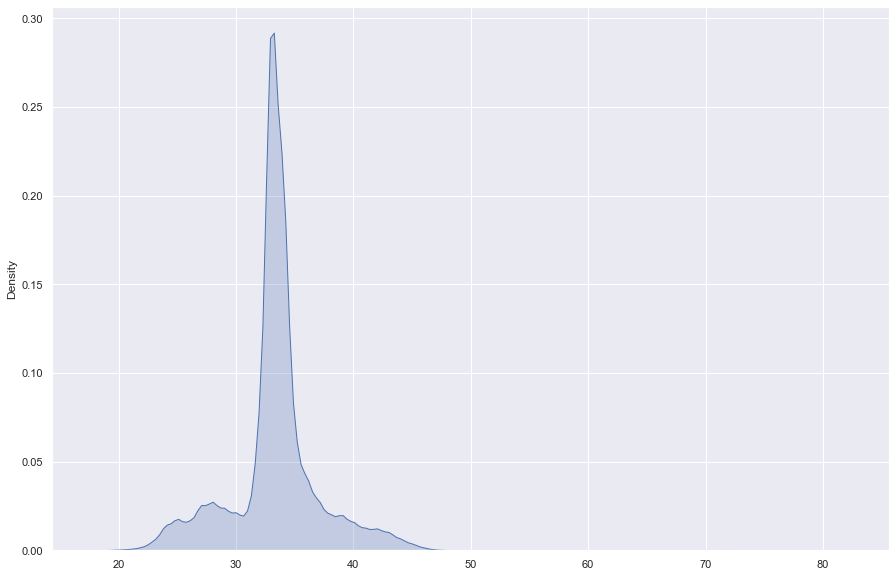

In [6]:
plt.figure(figsize=(15,10))
sns.kdeplot(intervals, shade=True);

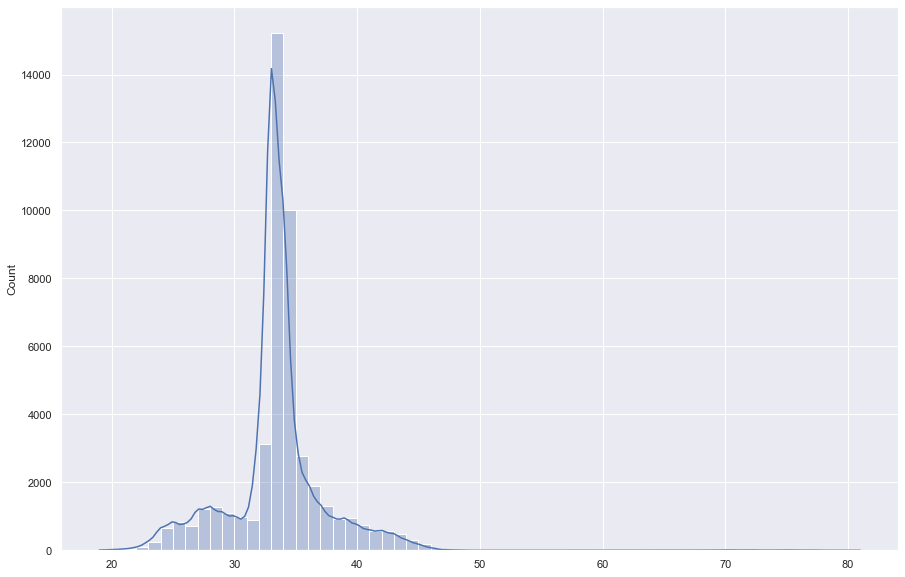

In [7]:
plt.figure(figsize=(15,10))
sns.histplot(intervals, kde=True,
             binwidth=1, alpha=0.33);

In [8]:
print(np.min(intervals))
print(np.max(intervals))
print(np.mean(intervals))
print(np.std(intervals))

print(1000 / 33.38)

19
81
33.387089956036526
4.02982527764797
29.958058717795083


Only looked at first subject here, but majority of samples are occuring around every 33 ms, which is just about 30 samples per second.  I suspect majority of outliers, especially for
large sample times, come from initial samples and/or when other people accidentally come into the tracker or tracking is lost for a bit.  I don't think we have to worry overly much
about sampling rates, seems pretty consistant.

# Distribution of Distance

Does the distance of joint(s) differ greatly?

Here for subject 0, do the two distance peaks possible represent the shift from standing to sitting here?

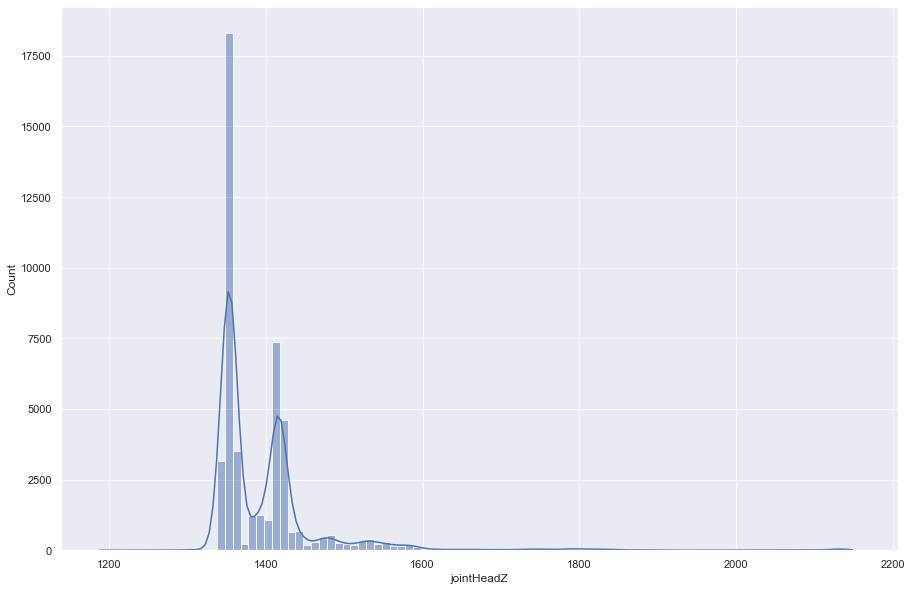

In [9]:
plt.figure(figsize=(15,10))
sns.histplot(x='jointHeadZ',
            binwidth=10,
            kde=True, 
            data=df);

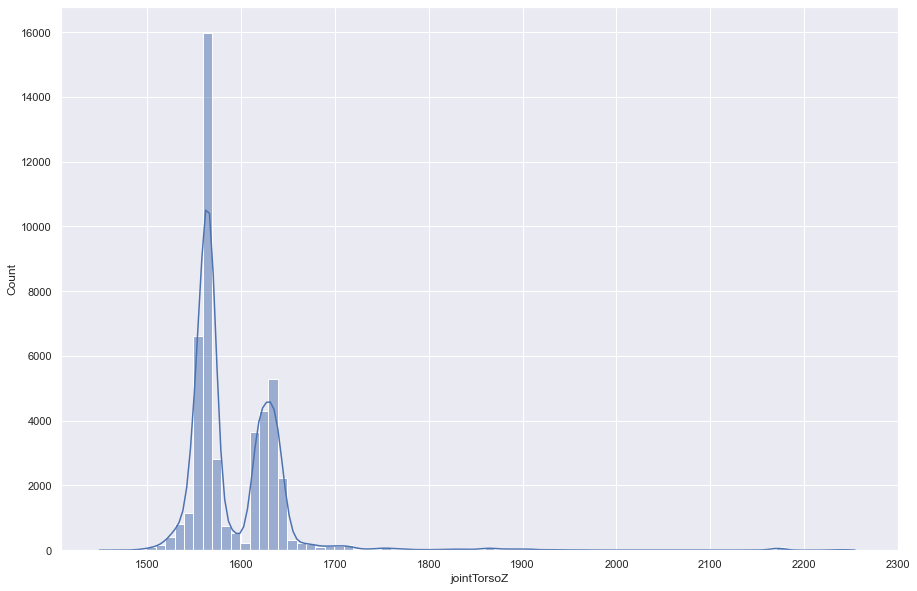

In [10]:
# do we see bimodal distribution in other joints
plt.figure(figsize=(15,10))
sns.histplot(x='jointTorsoZ',
            binwidth=10,
            kde=True, 
            data=df);

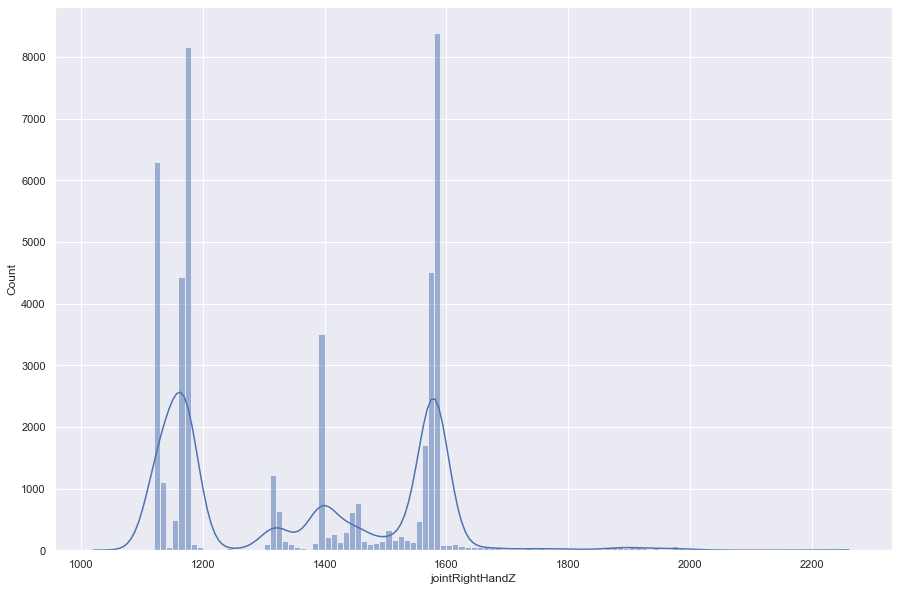

In [11]:
# do we see bimodal distribution in other joints
plt.figure(figsize=(15,10))
sns.histplot(x='jointRightHandZ',
            binwidth=10,
            kde=True, 
            data=df);

I suspect that the change in posture is the cause of this shift in distance.  We should be able to get a
positive model of Z position as independent variable with the posture (sitting vs. standing) as
dependent logistic variable.

# Participant Responses and Displacements

Here we have extracted the displacement rate for every participan response into the response-joint-displacements data file.
For every response made for every subject, we have calculated the ratio of the sum of the displacement made for each joint
divided by the time.  The time period that was extracted was from the 0.2 sec buffer before start of showing the queue, followed
by the cueue (dashed or solid box) for 1 sec, followed by the stimuli (blue or yellow triangle or square), after which the
participant reacted with a button press within 1.5 seconds.  We extracted all displacements that correspond to the
indicated time period, and calculated the rate in mm / sec as the sum of the displacements of the joint divided by the time
period over which we summed.

## Distribution of Joint Displacements for Responses

Lets visualize the displacements we see over all joints.  Any way to visualize these all in 1 figure using seaborn?
We can just use matplotlib subplots I suppose.

- The knee and foot (and to a lesser extent hip) are showing much larger displacement variation.  This is not surprising.  From
  observations, because of occlusion of desk our Kinect sensor is much more likely to not track well the legs and feet, so this
  variation is most likely noise from sensor readings.
- It appears that right side of body joints have smaller distributions than left side joint displacements.  The kinect sensor
  is on the right relative to the subject, so participants right arm and hip are closer to sensor than the left.  So is the further
  distance causing more noise for the left joint readings?  Would this reverse if we put kinect on left?  Would we eliminate if
  we could devise an experiment with kinect placed in front of subject?

In [12]:
data_file = '../data/response-joint-displacements.csv'
df = pd.read_csv(data_file)

In [13]:
df.describe()

,participant,session,condition,blockNum,trialNum,reactionTime,utcTime,jointHeadDisplacement,jointTorsoDisplacement,jointNeckDisplacement,...,jointLeftElbowDisplacement,jointRightElbowDisplacement,jointLeftHandDisplacement,jointRightHandDisplacement,jointLeftHipDisplacement,jointRightHipDisplacement,jointLeftKneeDisplacement,jointRightKneeDisplacement,jointLeftFootDisplacement,jointRightFootDisplacement
count,4704.00000,4704.0,4704.00000,4704.000000,4704.000000,4578.000000,4.704000e+03,4704.000000,4704.000000,4704.000000,...,4704.000000,4704.000000,4704.000000,4704.000000,4704.000000,4704.000000,4704.000000,4704.000000,4704.000000,4704.000000
mean,6.50000,1.0,6.50000,2.500000,25.000000,0.587177,1.636644e+09,68.413154,109.620481,72.306306,...,109.965535,106.943662,116.637899,114.491901,172.951705,169.959182,538.347341,512.062554,742.255123,538.405749
std,3.45242,0.0,3.45242,1.118153,14.143639,0.247759,7.687470e+04,63.716587,88.894723,61.946051,...,90.354938,106.004246,101.127198,147.285739,133.871604,131.938338,837.209124,542.241127,1369.020769,746.712664
min,1.00000,1.0,1.00000,1.000000,1.000000,0.106912,1.636562e+09,21.533116,28.879708,25.976386,...,20.577466,1.291326,35.363527,6.320364,44.214155,43.687801,44.212334,43.786532,44.213822,0.000000
25%,3.75000,1.0,3.75000,1.750000,13.000000,0.397405,1.636572e+09,43.539444,62.542373,41.899525,...,66.453223,47.266345,68.834981,46.081439,107.295394,96.123325,122.531645,157.639820,122.926681,106.353337
50%,6.50000,1.0,6.50000,2.500000,25.000000,0.525848,1.636623e+09,54.449897,83.612683,53.464073,...,87.745517,78.167698,90.708378,78.041404,137.340240,134.036355,184.320343,268.976799,196.099919,238.505460
75%,9.25000,1.0,9.25000,3.250000,37.000000,0.717686,1.636736e+09,70.204148,127.291341,81.871312,...,119.227357,132.125078,121.693235,134.637785,192.648264,202.101727,532.319767,676.507815,619.312572,640.982414
max,12.00000,1.0,12.00000,4.000000,49.000000,1.466526,1.636748e+09,1600.613448,1126.732394,1204.091096,...,1345.467541,1453.554864,1345.468265,2499.303866,1779.127668,1712.935028,6111.910385,3213.389215,10456.662510,5150.116013


In [14]:
df.shape

(4704, 33)

In [15]:
df.columns

Index(['participant', 'session', 'condition', 'trialType', 'posture',
       'blockNum', 'trialNum', 'switchTrialType', 'congruantTrialType',
       'cueType', 'shapeType', 'shapeColor', 'response', 'correctResponse',
       'correct', 'reactionTime', 'date', 'utcTime', 'jointHeadDisplacement',
       'jointTorsoDisplacement', 'jointNeckDisplacement',
       'jointLeftShoulderDisplacement', 'jointRightShoulderDisplacement',
       'jointLeftElbowDisplacement', 'jointRightElbowDisplacement',
       'jointLeftHandDisplacement', 'jointRightHandDisplacement',
       'jointLeftHipDisplacement', 'jointRightHipDisplacement',
       'jointLeftKneeDisplacement', 'jointRightKneeDisplacement',
       'jointLeftFootDisplacement', 'jointRightFootDisplacement'],
      dtype='object')

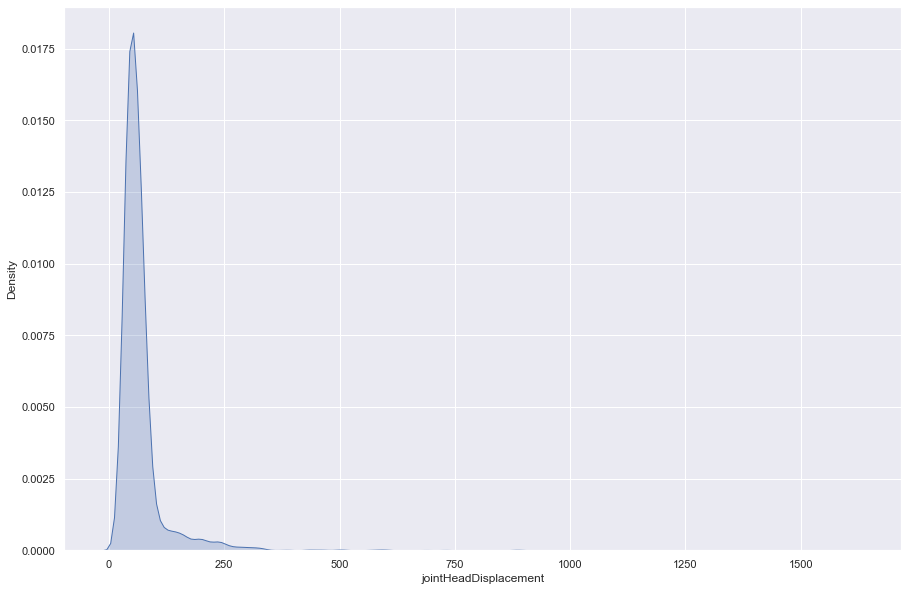

In [16]:
# distribution of head joint displacement over all participant responses
plt.figure(figsize=(15,10))
sns.kdeplot(x='jointHeadDisplacement', shade=True, data=df);

In [17]:
joint_list = [
    'jointHeadDisplacement',
    'jointNeckDisplacement',
    'jointLeftShoulderDisplacement',
    'jointRightShoulderDisplacement',
    'jointLeftElbowDisplacement',
    'jointRightElbowDisplacement',
    'jointLeftHandDisplacement',
    'jointRightHandDisplacement',
    'jointTorsoDisplacement',
    'jointLeftHipDisplacement',
    'jointRightHipDisplacement',
    'jointLeftKneeDisplacement',
    'jointRightKneeDisplacement',
    'jointLeftFootDisplacement',
    'jointRightFootDisplacement'
]

(-100.0, 600.0)

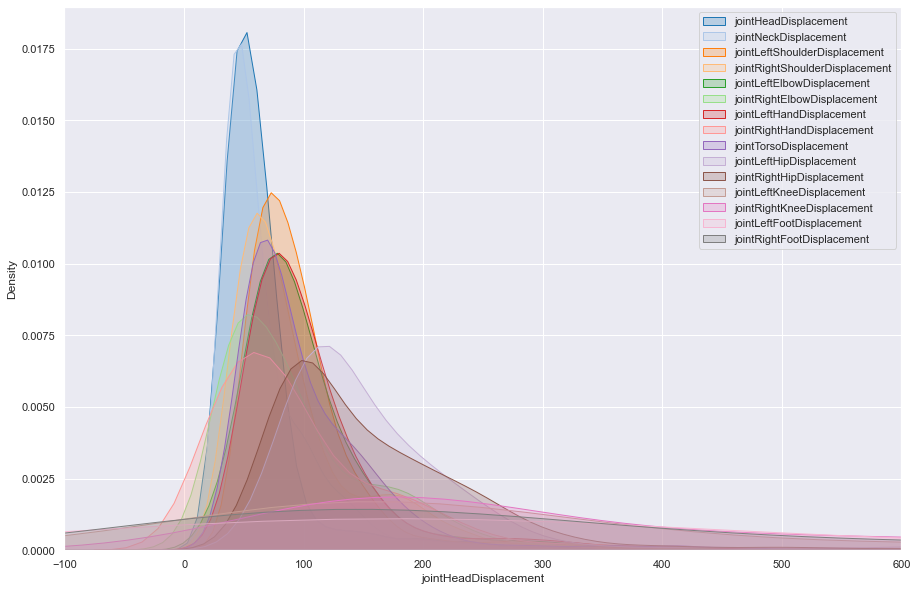

In [18]:
plt.figure(figsize=(15,10))
colors = plt.cm.tab20.colors

for idx, joint in enumerate(joint_list):
    sns.kdeplot(x=joint, label=joint, shade=True, color=colors[idx], data=df)
plt.legend();
plt.xlim([-100, 600])

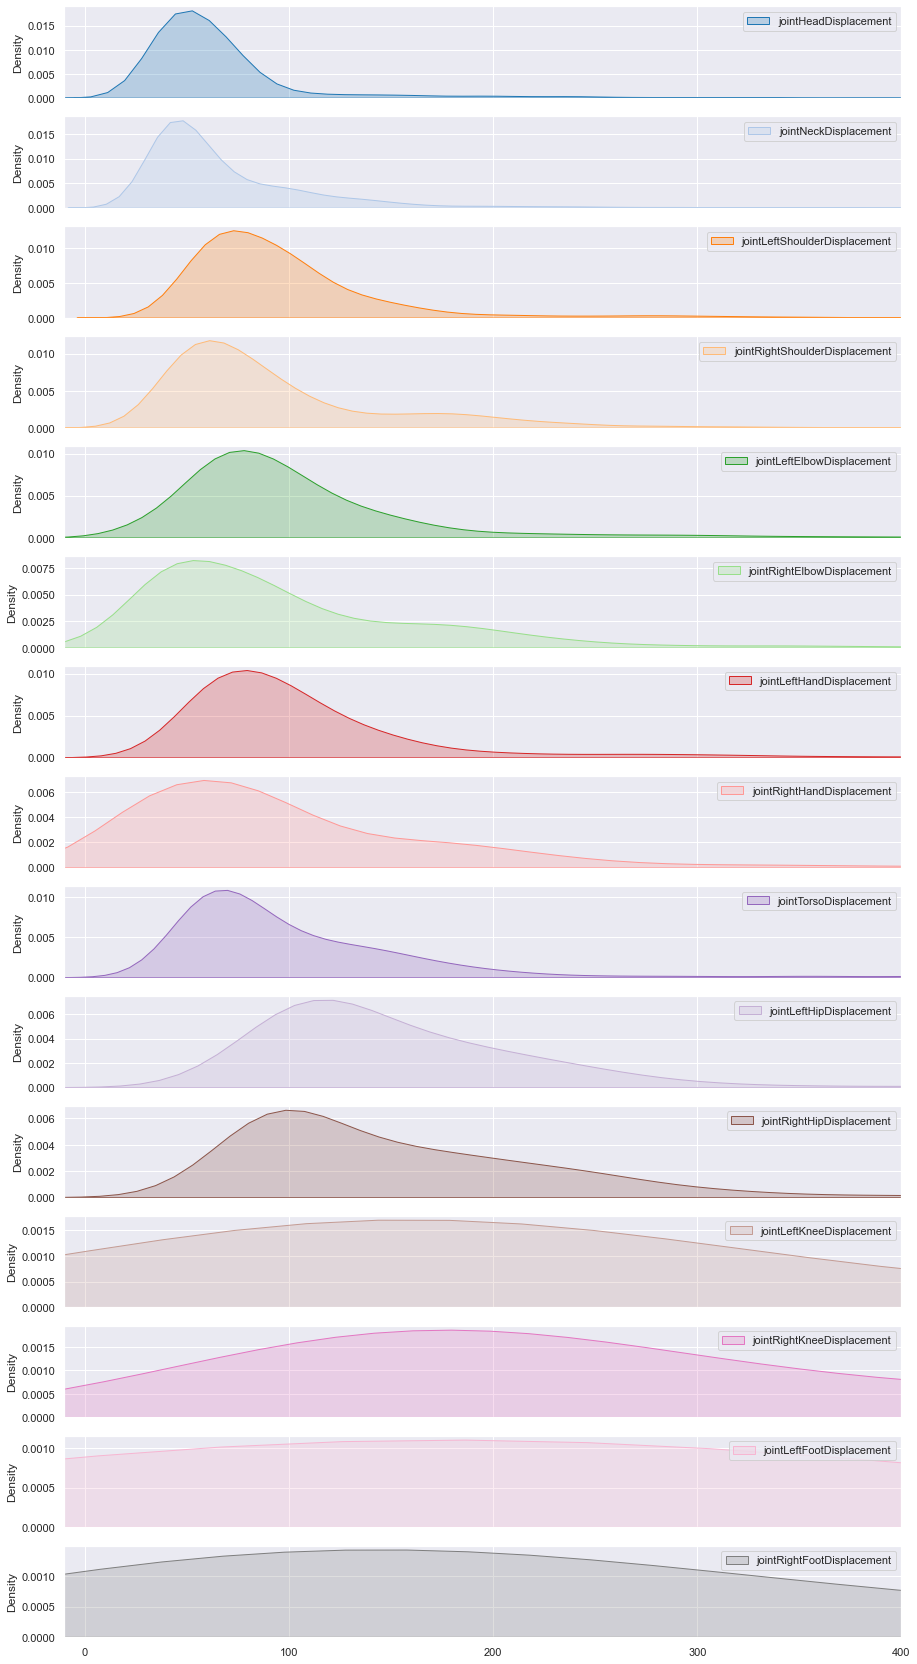

In [19]:
fig, axes = plt.subplots(15,1, figsize=(15,30))

for idx, joint in enumerate(joint_list):
    plt.subplot(15, 1, idx+1)
    ax = axes[idx]
    sns.kdeplot(ax=ax, x=joint, label=joint, shade=True, color=colors[idx], data=df)
    ax.legend()
    ax.set_xlim([-10, 400])
    ax.set_xticks([0, 100, 200, 300, 400])
    ax.set_xticklabels(['', '', '', '', ''])
    ax.set_xlabel('')
    #ax.grid()

ax.set_xticklabels(['0', '100', '200', '300', '400']);


## Joint Displacement by Experiment Conditions

Does distribution of the displacement seem to vary by switch/noswitch, standing/sitting, congruant/incongruant?

### standing vs. sitting posture

Text(0.5, 1.0, 'jointHeadDisplacement displacement by standing / sitting conditions')

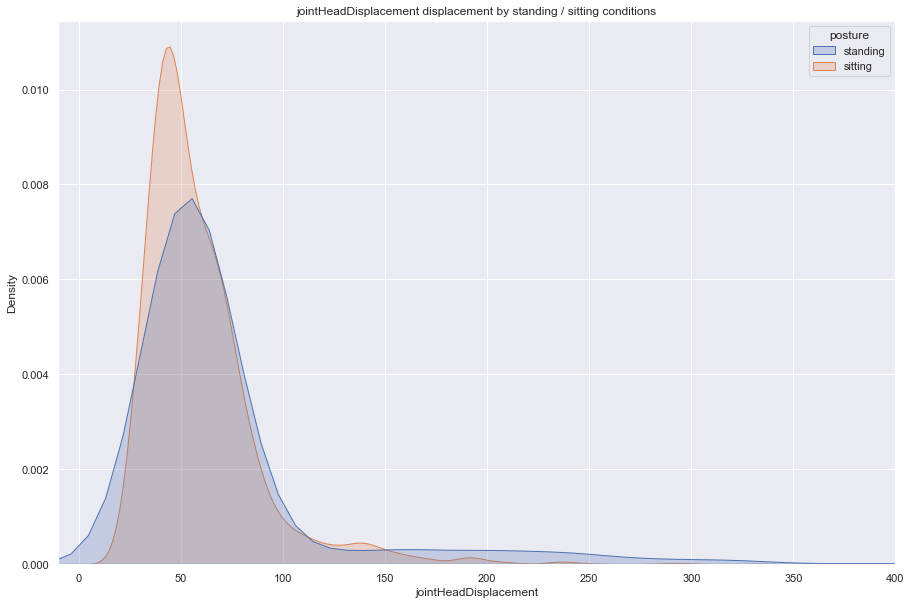

In [20]:
plt.figure(figsize=(15,10))
joint='jointHeadDisplacement'
sns.kdeplot(x=joint, label=joint,
            hue='posture',
            shade=True, 
            data=df)
plt.xlim([-10, 400])
title_str = '%s displacement by standing / sitting conditions' % joint
plt.title(title_str)

Text(0.5, 1.0, 'jointTorsoDisplacement displacement by standing / sitting conditions')

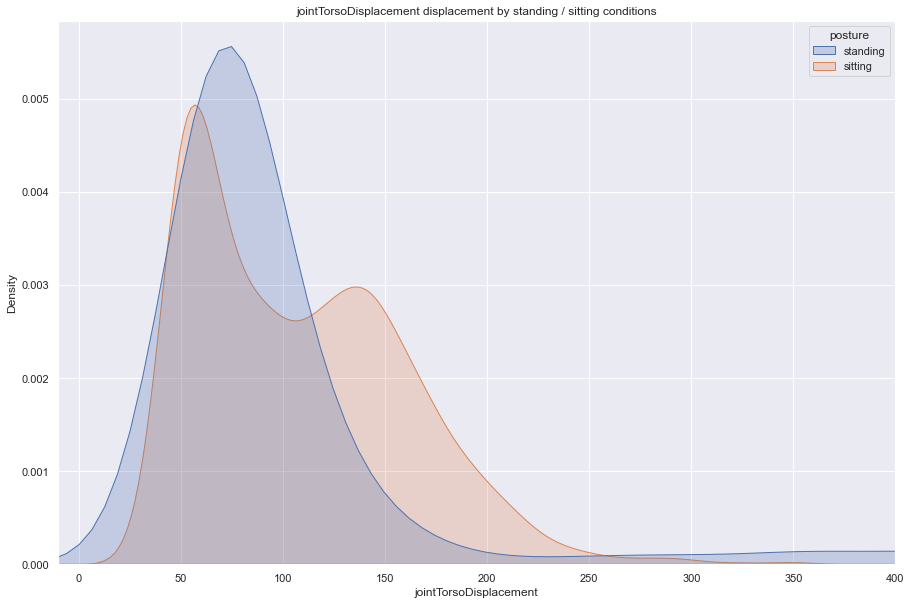

In [21]:
plt.figure(figsize=(15,10))
joint='jointTorsoDisplacement'
sns.kdeplot(x=joint, label=joint,
            hue='posture',
            shade=True, 
            data=df)
plt.xlim([-10, 400])
title_str = '%s displacement by standing / sitting conditions' % joint
plt.title(title_str)

Text(0.5, 1.0, 'jointRightHandDisplacement displacement by standing / sitting conditions')

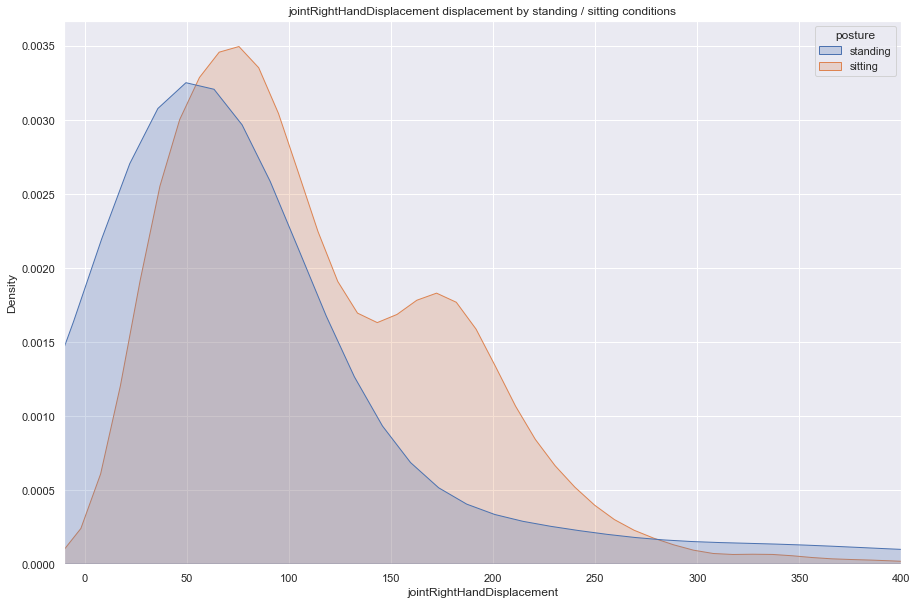

In [22]:
plt.figure(figsize=(15,10))
joint='jointRightHandDisplacement'
sns.kdeplot(x=joint, label=joint,
            hue='posture',
            shade=True, 
            data=df)
plt.xlim([-10, 400])
title_str = '%s displacement by standing / sitting conditions' % joint
plt.title(title_str)

Text(0.5, 1.0, 'jointLeftHandDisplacement displacement by standing / sitting conditions')

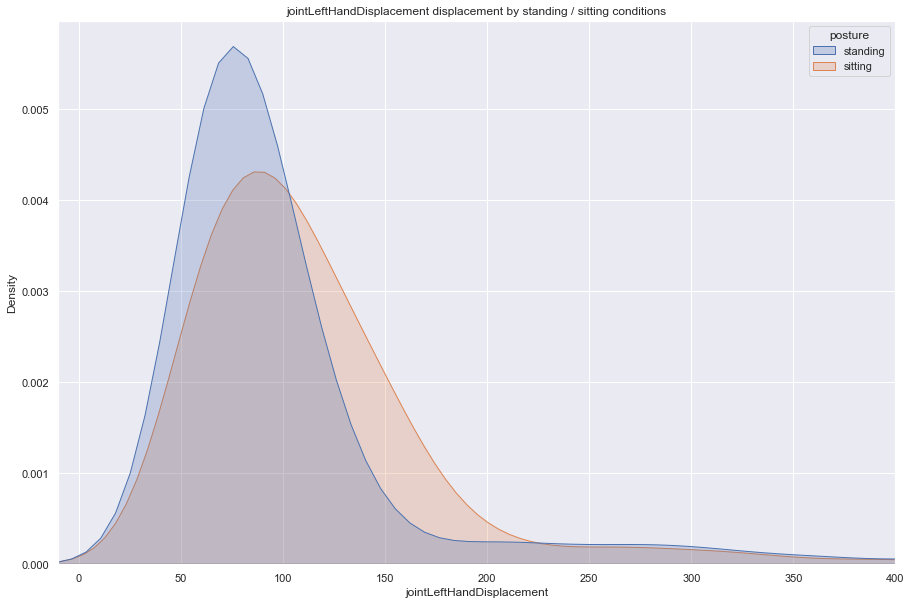

In [23]:
plt.figure(figsize=(15,10))
joint='jointLeftHandDisplacement'
sns.kdeplot(x=joint, label=joint,
            hue='posture',
            shade=True, 
            data=df)
plt.xlim([-10, 400])
title_str = '%s displacement by standing / sitting conditions' % joint
plt.title(title_str)

### congruant vs. incongruant trials

In [24]:
# drop buffer trials from following displays
mask = df.congruantTrialType != 'buffer'
df = df[mask]

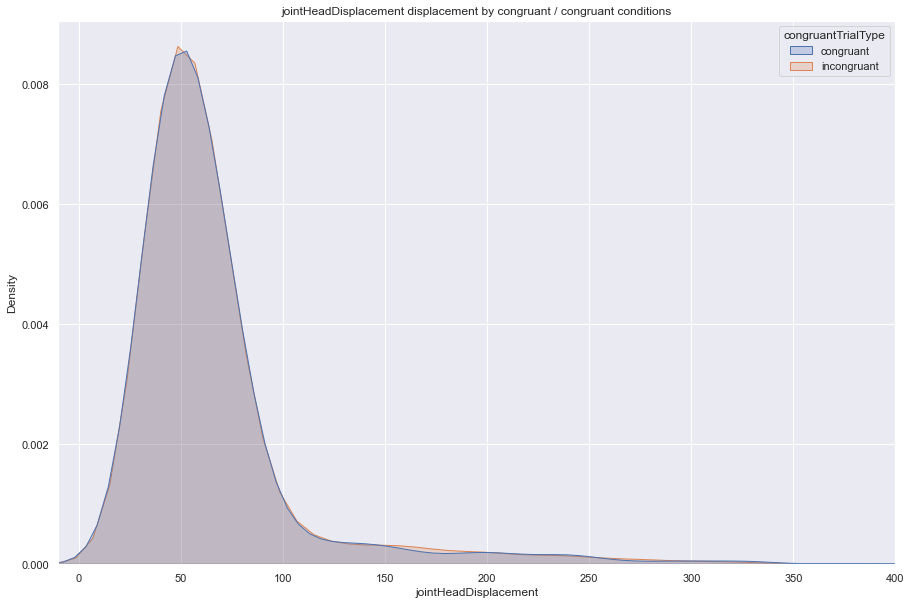

In [25]:
plt.figure(figsize=(15,10))
joint='jointHeadDisplacement'
sns.kdeplot(x=joint, label=joint,
            hue='congruantTrialType',
            shade=True, 
            data=df)
plt.xlim([-10, 400])
title_str = '%s displacement by congruant / congruant conditions' % joint
plt.title(title_str);

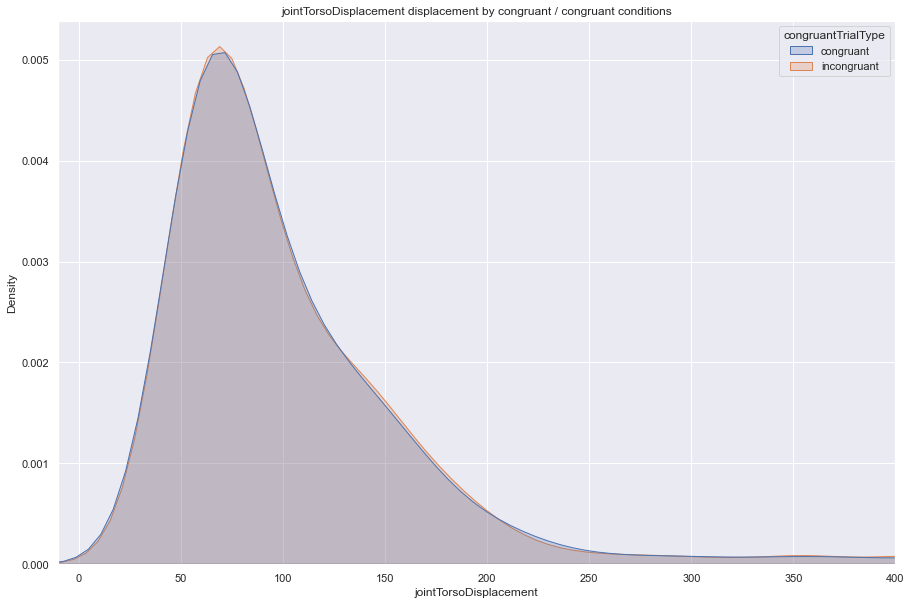

In [26]:
plt.figure(figsize=(15,10))
joint='jointTorsoDisplacement'
sns.kdeplot(x=joint, label=joint,
            hue='congruantTrialType',
            shade=True, 
            data=df)
plt.xlim([-10, 400])
title_str = '%s displacement by congruant / congruant conditions' % joint
plt.title(title_str);

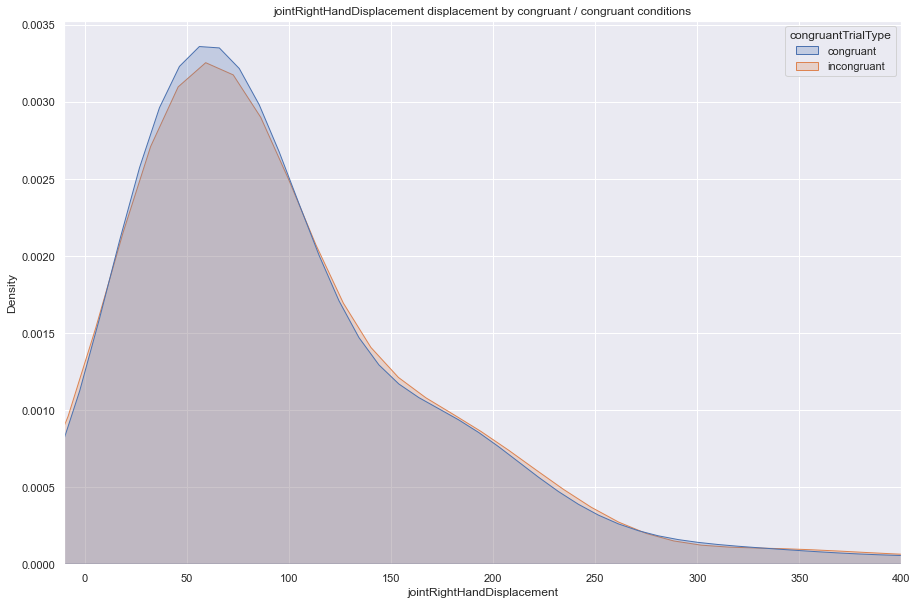

In [27]:
plt.figure(figsize=(15,10))
joint='jointRightHandDisplacement'
sns.kdeplot(x=joint, label=joint,
            hue='congruantTrialType',
            shade=True, 
            data=df)
plt.xlim([-10, 400])
title_str = '%s displacement by congruant / congruant conditions' % joint
plt.title(title_str);

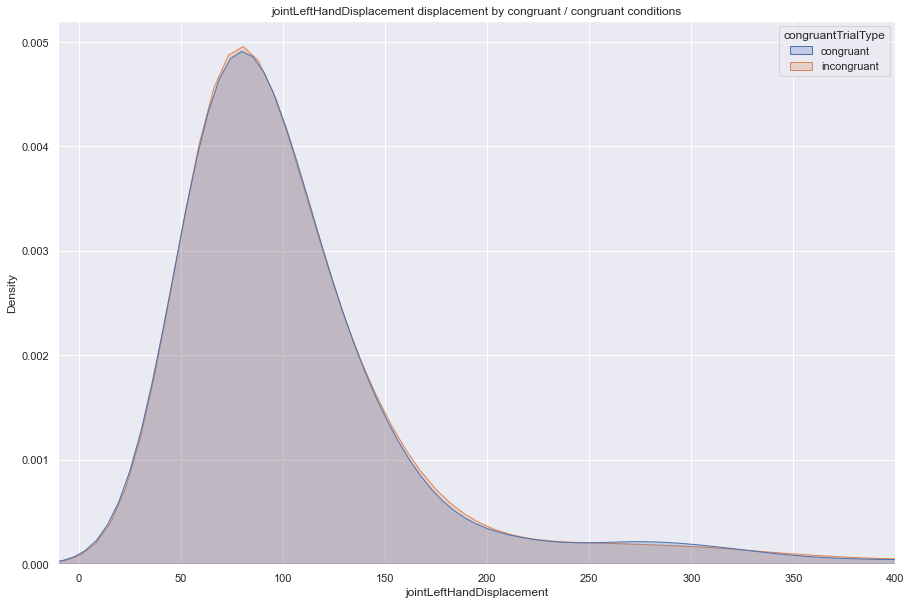

In [28]:
plt.figure(figsize=(15,10))
joint='jointLeftHandDisplacement'
sns.kdeplot(x=joint, label=joint,
            hue='congruantTrialType',
            shade=True, 
            data=df)
plt.xlim([-10, 400])
title_str = '%s displacement by congruant / congruant conditions' % joint
plt.title(title_str);

### switch vs. noswitch


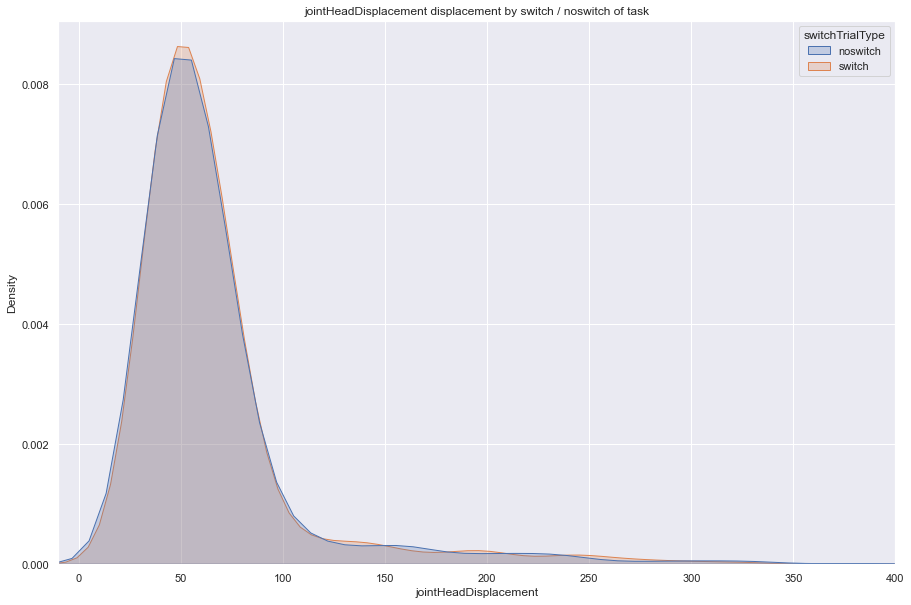

In [29]:
plt.figure(figsize=(15,10))
joint='jointHeadDisplacement'
sns.kdeplot(x=joint, label=joint,
            hue='switchTrialType',
            shade=True, 
            data=df)
plt.xlim([-10, 400])
title_str = '%s displacement by switch / noswitch of task' % joint
plt.title(title_str);

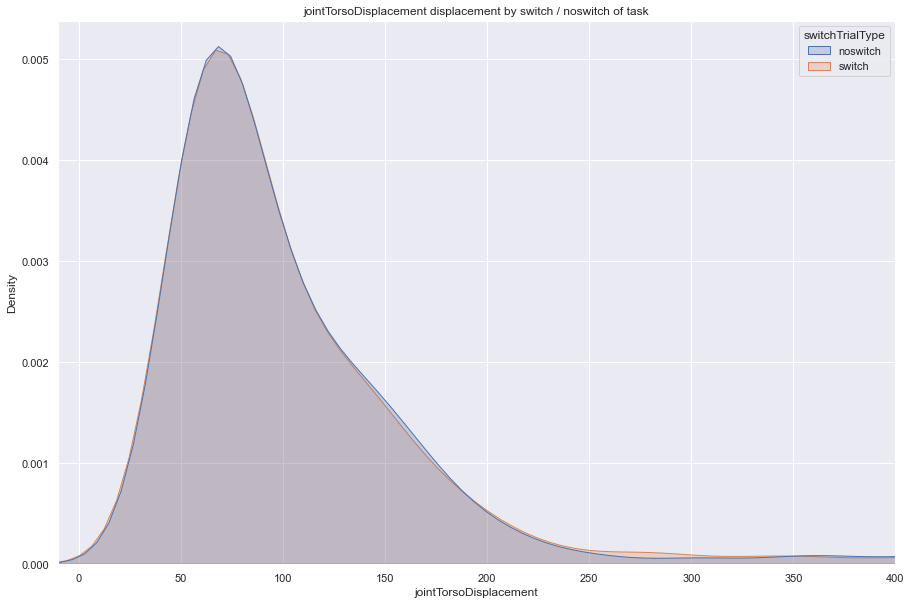

In [30]:
plt.figure(figsize=(15,10))
joint='jointTorsoDisplacement'
sns.kdeplot(x=joint, label=joint,
            hue='switchTrialType',
            shade=True, 
            data=df)
plt.xlim([-10, 400])
title_str = '%s displacement by switch / noswitch of task' % joint
plt.title(title_str);

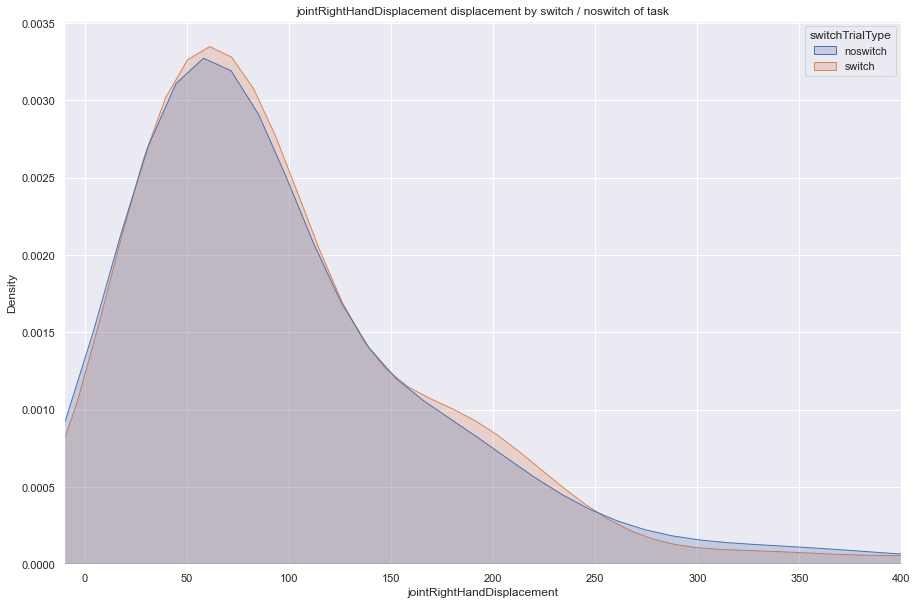

In [31]:
plt.figure(figsize=(15,10))
joint='jointRightHandDisplacement'
sns.kdeplot(x=joint, label=joint,
            hue='switchTrialType',
            shade=True, 
            data=df)
plt.xlim([-10, 400])
title_str = '%s displacement by switch / noswitch of task' % joint
plt.title(title_str);

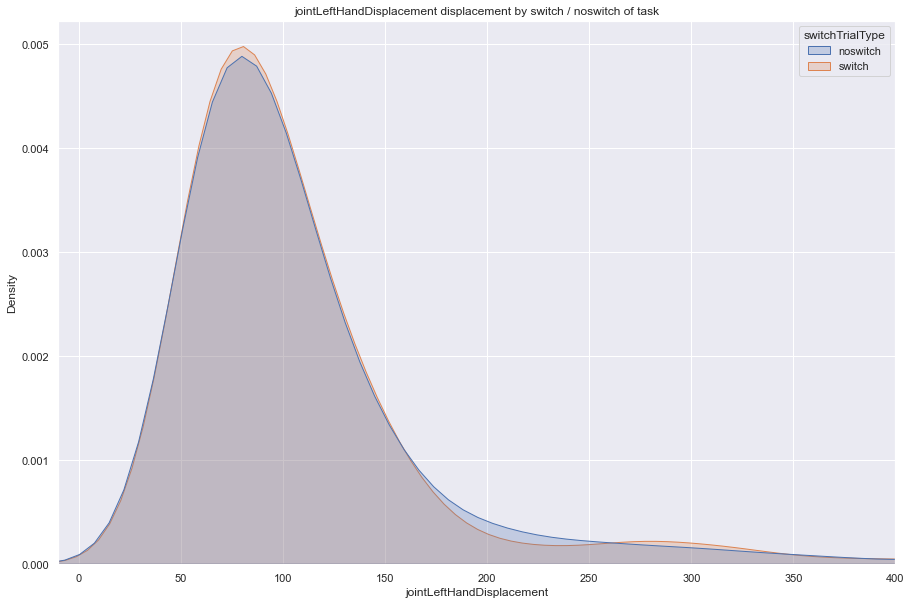

In [32]:
plt.figure(figsize=(15,10))
joint='jointLeftHandDisplacement'
sns.kdeplot(x=joint, label=joint,
            hue='switchTrialType',
            shade=True, 
            data=df)
plt.xlim([-10, 400])
title_str = '%s displacement by switch / noswitch of task' % joint
plt.title(title_str);

## Logistic Regression Models to Predict Correct / Incorrect

Do any of the displacements work as model parameters as independent variables to predict
correct/incorrect response as the independent variable?

All of the coefficients of the fits are really small, so even when it looks like some P value, there is nothing significant being
found in the models here.  Small pseudo- $R^2$ also indicate this.

In [33]:
# need a column that is numeric with 0 for no and 1 for yes for logistic regression...
correct_map = {
    'no': 0.0,
    'yes': 1.0,
}

df['correctLabel'] = 0.0

In [34]:
df['correctLabel'] = df.correct.map(correct_map)

In [35]:
df.correctLabel.sum()

3969.0

In [36]:
# extract X inputs and y outputs to make it easier to run logistic regression with statsmodel
# add in the constant bias term as well as statsmodel requires
y = df.correctLabel
X = df.jointHeadDisplacement
X = sm.add_constant(X)

# fit the logistic regression
logit = sm.Logit(y, X)
model = logit.fit()

# summarize the fit
model.summary()

Optimization terminated successfully.
         Current function value: 0.402222
         Iterations 6


/home/dash/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           correctLabel   No. Observations:                 4608
Model:                          Logit   Df Residuals:                     4606
Method:                           MLE   Df Model:                            1
Date:                Sun, 14 Nov 2021   Pseudo R-squ.:               0.0008020
Time:                        16:10:21   Log-Likelihood:                -1853.4
converged:                       True   LL-Null:                       -1854.9
Covariance Type:            nonrobust   LLR p-value:                   0.08455
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.8978      0.059     32.320      0.000       1.783       2.013
jointHeadDisplacement    -0.0010      0.001     -1.809      0.070      -0.002    8.55e-05
=========================================================================================
"""

In [37]:
# extract X inputs and y outputs to make it easier to run logistic regression with statsmodel
# add in the constant bias term as well as statsmodel requires
y = df.correctLabel
X = df.jointTorsoDisplacement
X = sm.add_constant(X)

# fit the logistic regression
logit = sm.Logit(y, X)
model = logit.fit()

# summarize the fit
model.summary()

Optimization terminated successfully.
         Current function value: 0.402213
         Iterations 6


/home/dash/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           correctLabel   No. Observations:                 4608
Model:                          Logit   Df Residuals:                     4606
Method:                           MLE   Df Model:                            1
Date:                Sun, 14 Nov 2021   Pseudo R-squ.:               0.0008257
Time:                        16:10:21   Log-Likelihood:                -1853.4
converged:                       True   LL-Null:                       -1854.9
Covariance Type:            nonrobust   LLR p-value:                   0.08008
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.9139      0.065     29.326      0.000       1.786       2.042
jointTorsoDisplacement    -0.0008      0.000     -1.809      0.070      -0.002    6.53e-05
==========================================================================================
"""

In [38]:
# extract X inputs and y outputs to make it easier to run logistic regression with statsmodel
# add in the constant bias term as well as statsmodel requires
y = df.correctLabel
X = df.jointRightHandDisplacement
X = sm.add_constant(X)

# fit the logistic regression
logit = sm.Logit(y, X)
model = logit.fit()

# summarize the fit
model.summary()

Optimization terminated successfully.
         Current function value: 0.402507
         Iterations 6


/home/dash/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           correctLabel   No. Observations:                 4608
Model:                          Logit   Df Residuals:                     4606
Method:                           MLE   Df Model:                            1
Date:                Sun, 14 Nov 2021   Pseudo R-squ.:               9.544e-05
Time:                        16:10:21   Log-Likelihood:                -1854.8
converged:                       True   LL-Null:                       -1854.9
Covariance Type:            nonrobust   LLR p-value:                    0.5518
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          1.8460      0.054     34.334      0.000       1.741       1.951
jointRightHandDisplacement    -0.0002      0.000     -0.606      0.545      -0.001       0.000
==============================================================================================
"""

In [39]:
# extract X inputs and y outputs to make it easier to run logistic regression with statsmodel
# add in the constant bias term as well as statsmodel requires
y = df.correctLabel
X = df.jointLeftHandDisplacement
X = sm.add_constant(X)

# fit the logistic regression
logit = sm.Logit(y, X)
model = logit.fit()

# summarize the fit
model.summary()

Optimization terminated successfully.
         Current function value: 0.402247
         Iterations 6


/home/dash/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           correctLabel   No. Observations:                 4608
Model:                          Logit   Df Residuals:                     4606
Method:                           MLE   Df Model:                            1
Date:                Sun, 14 Nov 2021   Pseudo R-squ.:               0.0007410
Time:                        16:10:21   Log-Likelihood:                -1853.6
converged:                       True   LL-Null:                       -1854.9
Covariance Type:            nonrobust   LLR p-value:                   0.09731
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         1.9042      0.063     30.217      0.000       1.781       2.028
jointLeftHandDisplacement    -0.0007      0.000     -1.713      0.087      -0.001    9.43e-05
=============================================================================================
"""

### Multi-factor Logistic Regression

Lets try model with all of the displacement parameters to predict correct/incorrect.

Likewise some P values look significant, but all coefficients are really small.  Nothing is really being found with a basic logistic regression
for this kinect displacement data.

In [40]:
# extract X inputs and y outputs to make it easier to run logistic regression with statsmodel
# add in the constant bias term as well as statsmodel requires
y = df.correctLabel
X = df[joint_list]
X = sm.add_constant(X)

# fit the logistic regression
logit = sm.Logit(y, X)
model = logit.fit()

# summarize the fit
model.summary()

/home/dash/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.382251
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           correctLabel   No. Observations:                 4608
Model:                          Logit   Df Residuals:                     4592
Method:                           MLE   Df Model:                           15
Date:                Sun, 14 Nov 2021   Pseudo R-squ.:                 0.05041
Time:                        16:10:21   Log-Likelihood:                -1761.4
converged:                       True   LL-Null:                       -1854.9
Covariance Type:            nonrobust   LLR p-value:                 9.043e-32
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              2.3280      0.092     25.207      0.000       2.147       2.509
jointHeadDisplacement              0.0080      0.002      3.526      0.000       0.004       0.012
jointNeckDisplacement             -0.0115      0.006     -1.876      0.061      -0.024       0.001
jointLeftShoulderDisplacement     -0.0074      0.003     -2.607      0.009      -0.013      -0.002
jointRightShoulderDisplacement     0.0013      0.002      0.538      0.590      -0.003       0.006
jointLeftElbowDisplacement         0.0014      0.002      0.574      0.566      -0.003       0.006
jointRightElbowDisplacement       -0.0036      0.001     -3.139      0.002      -0.006      -0.001
jointLeftHandDisplacement       9.689e-05      0.002      0.052      0.958      -0.004       0.004
jointRightHandDisplacement         0.0028      0.001      3.101      0.002       0.001       0.005
jointTorsoDisplacement             0.0221      0.007      3.049      0.002       0.008       0.036
jointLeftHipDisplacement          -0.0063      0.003     -2.403      0.016      -0.011      -0.001
jointRightHipDisplacement         -0.0030      0.002     -1.245      0.213      -0.008       0.002
jointLeftKneeDisplacement         -0.0007      0.000     -1.780      0.075      -0.001    7.01e-05
jointRightKneeDisplacement        -0.0007      0.000     -4.537      0.000      -0.001      -0.000
jointLeftFootDisplacement          0.0005      0.000      2.169      0.030    4.93e-05       0.001
jointRightFootDisplacement     -7.769e-05      0.000     -0.628      0.530      -0.000       0.000
==================================================================================================
"""

What kind of accuracy does a model like this get?  Lets switch to scikit-learn and create a model and measure
prediction accuracy.  

In [41]:
model = LogisticRegression(max_iter=10000)
model.fit(X, y)

model.score(X, y)

0.8600260416666666

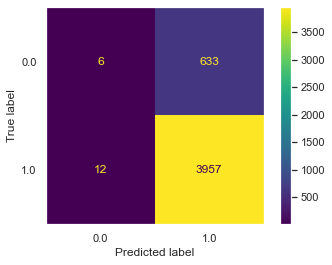

In [42]:
plot_confusion_matrix(model, X, y)
plt.grid()

Oh right, most of the responses are correct responses, so data is skewed and this is not really doing very good.  The proprotion of correct responses is:

In [43]:
print(df.correctLabel.sum())
print(df.correctLabel.sum() / df.shape[0])

3969.0
0.861328125


So actually its just doing chance level here basically, not discriminating.


## Linear Regression Models to Predict Reaction Time

Does joint displacement have any predictive power of the participants reaction time as the dependent variable?

Likewise no coefficients of any significance found with a linear regression model for this data as a predictor
of reaction time.

In [44]:
# some reaction times are null, when response not made in time.  Only consider non null reaction times
df_rt = df.dropna(subset=['reactionTime'])
df_rt.shape

(4486, 34)

In [45]:
# extract X inputs and y outputs to make it easier to run logistic regression with statsmodel
# add in the constant bias term as well as statsmodel requires
y = df_rt.reactionTime
X = df_rt[joint_list]
X = sm.add_constant(X)

# fit the logistic regression
linreg = sm.OLS(y, X)
model = linreg.fit()

# summarize the fit
model.summary()

/home/dash/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           reactionTime   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     20.74
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           3.19e-55
Time:                        16:10:22   Log-Likelihood:                 60.592
No. Observations:                4486   AIC:                            -89.18
Df Residuals:                    4470   BIC:                             13.35
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.4948      0.007     66.133      0.000       0.480       0.509
jointHeadDisplacement              0.0002      0.000      0.961      0.336      -0.000       0.001
jointNeckDisplacement             -0.0022      0.001     -3.746      0.000      -0.003      -0.001
jointLeftShoulderDisplacement      0.0014      0.000      5.759      0.000       0.001       0.002
jointRightShoulderDisplacement     0.0003      0.000      1.648      0.099   -6.15e-05       0.001
jointLeftElbowDisplacement        -0.0004      0.000     -2.437      0.015      -0.001   -8.59e-05
jointRightElbowDisplacement        0.0002      0.000      2.247      0.025    2.92e-05       0.000
jointLeftHandDisplacement          0.0003      0.000      1.816      0.069   -2.03e-05       0.001
jointRightHandDisplacement        -0.0002   5.92e-05     -2.757      0.006      -0.000   -4.72e-05
jointTorsoDisplacement             0.0012      0.001      1.575      0.115      -0.000       0.003
jointLeftHipDisplacement          -0.0001      0.000     -0.561      0.575      -0.001       0.000
jointRightHipDisplacement         -0.0004      0.000     -1.896      0.058      -0.001    1.42e-05
jointLeftKneeDisplacement       2.498e-05   3.65e-05      0.685      0.493   -4.65e-05    9.65e-05
jointRightKneeDisplacement         0.0001   1.46e-05     10.015      0.000       0.000       0.000
jointLeftFootDisplacement      -1.154e-06   2.18e-05     -0.053      0.958   -4.38e-05    4.15e-05
jointRightFootDisplacement     -7.553e-05   1.13e-05     -6.702      0.000   -9.76e-05   -5.34e-05
==============================================================================
Omnibus:                      709.339   Durbin-Watson:                   1.415
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1105.903
Skew:                           1.110   Prob(JB):                    7.18e-241
Kurtosis:                       3.993   Cond. No.                     4.29e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""